In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# importar xgeboost
import xgboost as xgb

In [202]:
temp = pd.read_excel('temperature.xlsx')
temp.head()

,Date,Daily minimum temperatures
0,1981-01-01 00:00:00,20.7
1,1981-02-01 00:00:00,17.9
2,1981-03-01 00:00:00,18.8
3,1981-04-01 00:00:00,14.6
4,1981-05-01 00:00:00,15.8


In [203]:
temp['Date'] = pd.to_datetime(temp['Date'])

In [204]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        3647 non-null   datetime64[ns]
 1   Daily minimum temperatures  3647 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.1 KB


In [205]:
temp.set_index('Date', inplace=True)

In [206]:
temp.shape

(3647, 1)

In [207]:
temp.describe()

,Daily minimum temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [208]:
# renomear a coluna Daily minimum temperatures
temp.rename(columns={'Daily minimum temperatures': 'Temperatura'}, inplace=True)

In [209]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperatura  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [246]:
temp.Temperatura = temp.Temperatura.astype(float)

<AxesSubplot:xlabel='Date'>

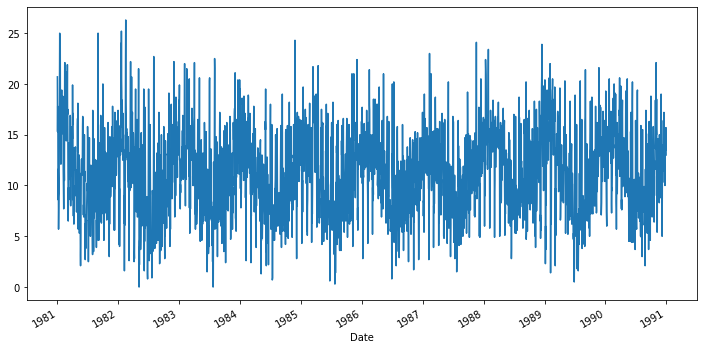

In [248]:
# Plotar a série temporal de temperatura
temp.Temperatura.plot(figsize=(12, 6))

In [211]:

temp.index.min(), temp.index.max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('1990-12-31 00:00:00'))

In [212]:
filtro = (temp.index >= '1988-01-01') & (temp.index <= '1990-12-31')

<AxesSubplot:xlabel='Date'>

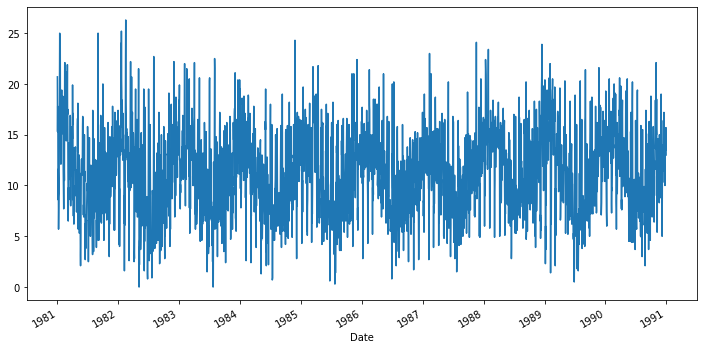

In [213]:
temp.Temperatura.plot(figsize=(12, 6))

<AxesSubplot:xlabel='Date'>

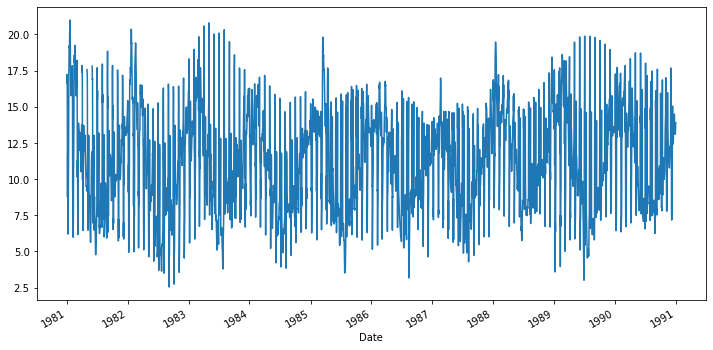

In [214]:
temp.Temperatura.rolling(7).mean().plot(figsize=(12, 6))

In [215]:
temp.Temperatura.diff(7)

Date
1981-01-01    NaN
1981-02-01    NaN
1981-03-01    NaN
1981-04-01    NaN
1981-05-01    NaN
             ... 
1990-12-27   -1.4
1990-12-28    0.5
1990-12-29    0.3
1990-12-30    1.8
1990-12-31    3.0
Name: Temperatura, Length: 3647, dtype: float64

In [216]:
temp.loc[filtro].diff()

,Temperatura
Date,
1988-01-01,NaN
1988-02-01,-1.0
1988-03-01,-0.8
1988-04-01,1.5
1988-05-01,-1.4
...,...
1990-12-27,-0.6
1990-12-28,-0.4
1990-12-29,-0.1


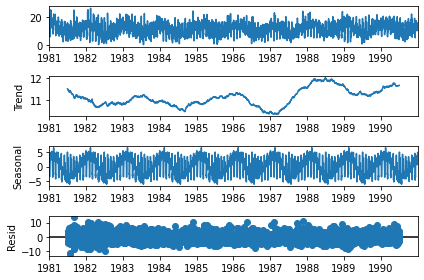

In [249]:
temp.sort_index(inplace=True)
sd = sm.tsa.seasonal_decompose(temp, model='add', period=365)
sd.plot();

In [250]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(temp['Temperatura'].dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-3.3315414129688166
p-valor:0.013526112195454373


In [219]:
# Auto ARIMA nos ajuda a buscar os melhores parâmetros
from pmdarima import auto_arima


fit_arima = auto_arima(temp, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           trace=True, 
                           error_action='ignore', 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=15.42 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=22211.573, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=20978.709, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=6.60 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=22068.931, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=20482.431, Time=1.37 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=15.09 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=6.20 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=20662.364, Time=1.50 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=20418.687, Time=2.69 sec
 ARIMA(2,1,0)(1,1,0)[6]             : AIC=20927.151, Time=1.61 sec
 ARIMA(2,1,0)(2,1,1)[6]             : AIC=inf, Time=18.59 sec
 ARIMA(2,1,0)(1,1,1)[6]             : AIC=inf, Time=10.17 sec
 ARIMA(3,1,0)(2,1,0)[6]             : AIC=20352.684, Time=3.34 sec
 ARIMA(3,1,0)(1,1,0)[6]             : AIC=20872.994

In [251]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(temp, order=(3,1,0), seasonal_order=(2,1,0,6))
resultado_sarimax = model.fit()

/home/valdir/anaconda3/envs/dnc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/valdir/anaconda3/envs/dnc/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83635D+00    |proj g|=  7.30654D-02

At iterate    5    f=  2.78870D+00    |proj g|=  2.58183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     12      1     0     0   7.987D-06   2.789D+00
  F =   2.7886871613512390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [252]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Temperatura   No. Observations:                 3647
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 6)   Log Likelihood              -10170.342
Date:                           Thu, 08 Jun 2023   AIC                          20352.684
Time:                                   23:13:34   BIC                          20389.883
Sample:                                        0   HQIC                         20365.933
                                          - 3647                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2718      0.016    -16.992      0.000      -0.303      -0.240
ar.L2         -0.1699      0.016    -10.713      0.000      -0.201      -0.139
ar.L3         -0.1370      0.016     -8.468      0.000      -0.169      -0.105
ar.S.L6       -0.7158      0.015    -47.236      0.000      -0.746      -0.686
ar.S.L12      -0.3666      0.015    -23.968      0.000      -0.397      -0.337
sigma2        15.6300      0.329     47.446      0.000      14.984      16.276
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                37.89
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [253]:
pred = resultado_sarimax.get_prediction(start=-60)
predicao_media = pred.predicted_mean

In [254]:
intervalo_confianca = pred.conf_int()
limite_abaixo = intervalo_confianca.iloc[:, 0]
limite_acima = intervalo_confianca.iloc[:, 1]
limite_abaixo[0], limite_acima[0]

(16.57468625739068, 32.07204772998071)

In [255]:
predicao_media[0]

24.323366993685696

In [257]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(temp.index)

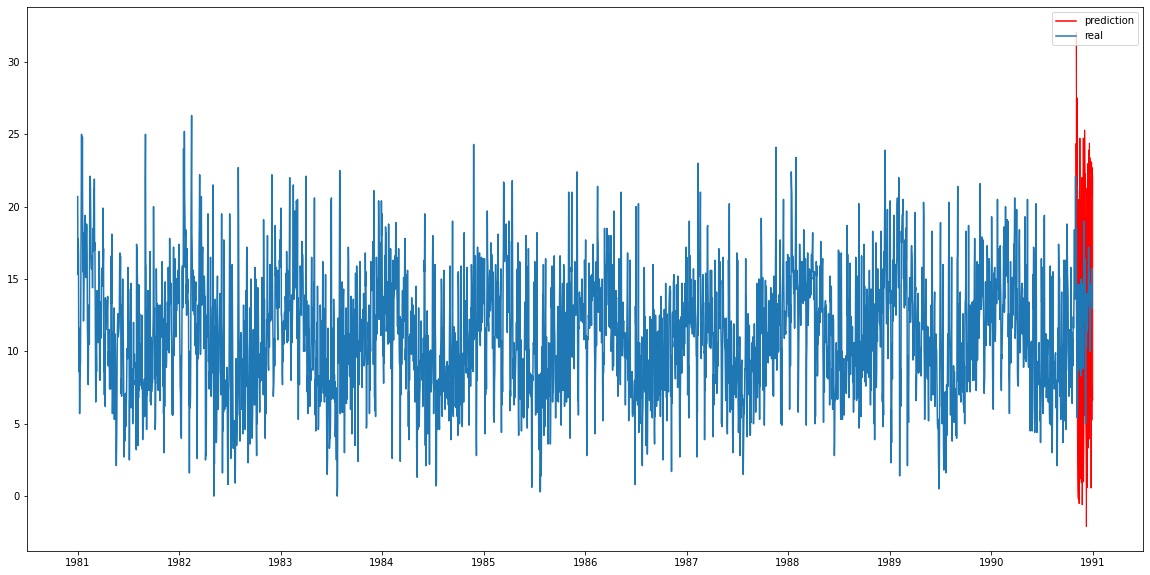

In [258]:
plt.figure(figsize=(20,10))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limite_abaixo, limite_acima, color='red')
plt.plot(datas, temp.values, label='real')
plt.legend()
plt.show()

In [259]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sarima = sqrt(mean_squared_error(temp[-60:].values,predicao_media.values))
print(rmse_sarima)

3.6910302591304567


In [260]:
treino = temp.loc[temp.index < '1985-12-31']
teste = temp.loc[temp.index >= '1985-12-31']

In [261]:
treino['target'] = treino.Temperatura.shift(-1)
treino.head()

/tmp/ipykernel_27028/3207062954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['target'] = treino.Temperatura.shift(-1)


,Temperatura,target
Date,,
1981-01-01,20.7,15.3
1981-01-02,15.3,17.8
1981-01-03,17.8,16.7
1981-01-04,16.7,8.6
1981-01-05,8.6,11.6


In [262]:
treino.isnull().sum()

Temperatura    0
target         1
dtype: int64

In [263]:
treino.dropna(inplace=True)

/tmp/ipykernel_27028/3273225221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino.dropna(inplace=True)


In [264]:
teste['target'] = teste.Temperatura.shift(-1)
teste.head()

/tmp/ipykernel_27028/3137126881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['target'] = teste.Temperatura.shift(-1)


,Temperatura,target
Date,,
1985-12-31,14.4,12.9
1986-01-01,12.9,14.6
1986-01-02,14.6,17.7
1986-01-03,17.7,10.2
1986-01-04,10.2,11.1


In [233]:
teste.isnull().sum()

Temperatura    0
target         1
dtype: int64

In [234]:
teste.loc[teste.target.isnull()]

,Temperatura,target
Date,,
1990-12-31,13.0,NaN


In [265]:
teste.dropna(inplace=True)

/tmp/ipykernel_27028/2059741479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste.dropna(inplace=True)


In [266]:
teste.head(), treino.head()

(            Temperatura  target
 Date                           
 1985-12-31         14.4    12.9
 1986-01-01         12.9    14.6
 1986-01-02         14.6    17.7
 1986-01-03         17.7    10.2
 1986-01-04         10.2    11.1,
             Temperatura  target
 Date                           
 1981-01-01         20.7    15.3
 1981-01-02         15.3    17.8
 1981-01-03         17.8    16.7
 1981-01-04         16.7     8.6
 1981-01-05          8.6    11.6)

In [267]:
x_treino = treino.loc[:,['Temperatura']].values
y_treino = treino.loc[:, ['target']].values
x_teste = teste.loc[:, ['Temperatura']].values
y_teste = teste.loc[:, ['target']].values

In [268]:
x_teste

array([[14.4],
       [12.9],
       [14.6],
       ...,
       [13.6],
       [13.5],
       [15.7]])

In [269]:
modelo_xgba = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000)
modelo_xgba.fit(x_treino,y_treino)

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

In [270]:
teste.iloc[0]

Temperatura    14.4
target         12.9
Name: 1985-12-31 00:00:00, dtype: float64

In [271]:
pred = modelo_xgba.predict(x_teste)
pred

array([15.346688,  9.873621, 13.950414, ..., 12.963813, 11.6737  ,
       14.008081], dtype=float32)

In [272]:
teste['predicao'] = pred
teste.head(), teste.tail()
teste

/tmp/ipykernel_27028/1541439283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['predicao'] = pred


,Temperatura,target,predicao
Date,,,
1985-12-31,14.4,12.9,15.346688
1986-01-01,12.9,14.6,9.873621
1986-01-02,14.6,17.7,13.950414
1986-01-03,17.7,10.2,14.708437
1986-01-04,10.2,11.1,11.116157
...,...,...,...
1990-12-26,14.6,14.0,13.950414
1990-12-27,14.0,13.6,13.837991
1990-12-28,13.6,13.5,12.963813


In [273]:
mean_squared_error(x_teste, pred)

3.0480429599241154